In [2]:
import os
import sys
import importlib
import moten
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

print(sys.path)
%pwd

os.chdir('/home/rfpred')
sys.path.append('/home/rfpred/')
sys.path.append('/home/rfpred/envs/rfenv/lib/python3.11/site-packages/')
sys.path.append('/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsdcode')

from classes.voxelsieve import VoxelSieve
from classes.natspatpred import NatSpatPred
NSP = NatSpatPred()
NSP.initialise()

# file_exists = os.path.isfile(f"{NSP.own_datapath}/visfeats/gabor_pyramid/gauss_checker_output.npy")


from funcs.reloads import Reloader

import importlib
import classes.utilities
from classes.utilities import Utilities

importlib.reload(classes.utilities)
from classes.utilities import Utilities

rl = Reloader()
NSP = rl.nsp()

import funcs.gaborpyr
importlib.reload(funcs.gaborpyr)
import funcs.gaborpyr

['/home/rfpred/notebooks/construction_work', '/home/rfpred/envs/rfenv/lib/python311.zip', '/home/rfpred/envs/rfenv/lib/python3.11', '/home/rfpred/envs/rfenv/lib/python3.11/lib-dynload', '', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages', '/home/rfpred/notebooks/alien_nbs/lgnpy', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsd_access-0.0.1.dev0-py3.11.egg', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/cifti-1.1-py3.11.egg']
Naturalistic Spatial Prediction class: Initialised

Class contains the following attributes:
 .analyse
 .attributes
 .cortex
 .datafetch
 .explore
 .hidden_methods
 .initialise
 .nsd_datapath
 .own_datapath
 .stimuli
 .subjects
 .utils


In [126]:
from funcs.gaborpyr import (
    isotropic_gaussian,
    circle_stim,
    random_dot,
    show,
    cut_corners,
    make_checker,
    plot_filter_locations,
    plot_filter_outputs,
    normalize_output,
    select_filters,
    cut_paste_mask,
    location_based_selection,
    filts_per_freq,
    orient_boolmask,
    gab_heatmap,
)

# Optimisation of gabor filter selection


### Create a stimulus that represents the visual region of which we want to quantify the content. To this end we'll convolve a nested checker stimulus with an isotropic gaussian.


In [127]:
subject = "subj01"
pixels = 425
degrees = 8.4
pix_per_deg = pixels / degrees

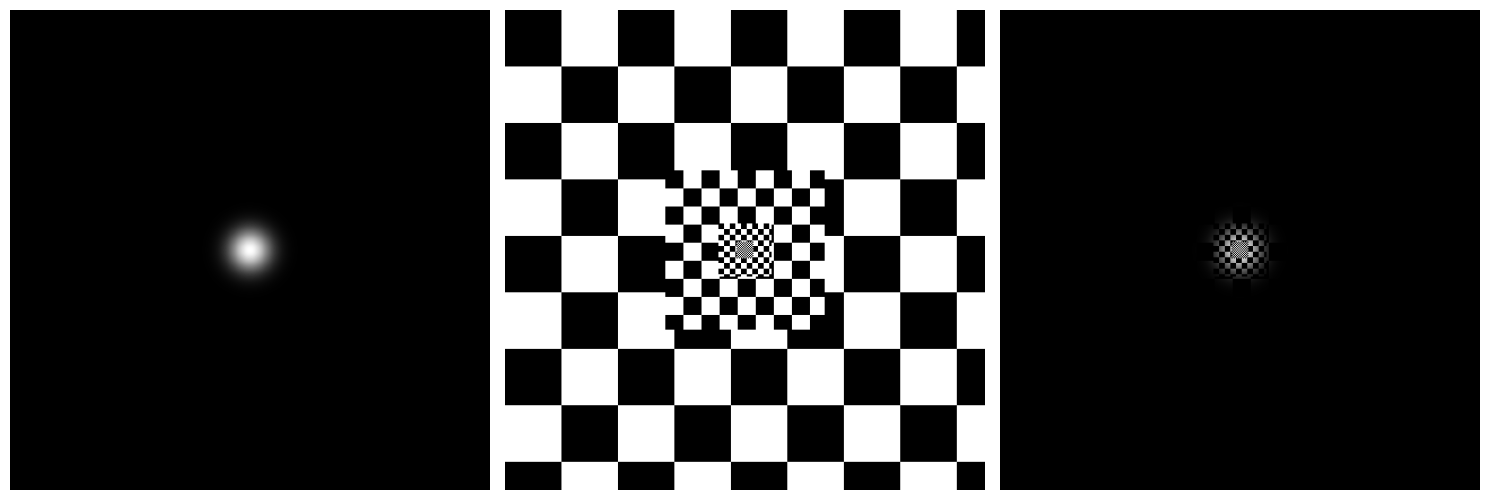

In [128]:
gauss = isotropic_gaussian(
    dims=(425, 425), sigma=pix_per_deg / 4
)  # Justify this 2.5 factor

checker_stim = make_checker(
    dims=(425, 425),
    checkercenter=(212, 212),
    scales=3,
    scaling_factor=3,
    checker_size=50,
    stride=0,
)

fig, axes = plt.subplots(1, 3, figsize=(15, 6))

for img_no, img in enumerate([gauss, checker_stim, checker_stim * gauss]):
    axes[img_no].imshow(img, cmap="gist_gray")
    axes[img_no].axis("off")
plt.tight_layout()

gauss_check_stack = np.stack([gauss, checker_stim * gauss], axis=0)

### Here we build our gabor filter pyramid given a set of defined parameters.


In [ ]:
# The pymoten standard values:
    # def __init__(self,
    #              stimulus_vhsize=(576, 1024),
    #              stimulus_fps=24,
    #              temporal_frequencies=[0,2,4],
    #              spatial_frequencies=[0,2,4,8,16],
    #              spatial_directions=[0,45,90,135,180,225,270,315],
    #              sf_gauss_ratio=0.6,
    #              max_spatial_env=0.3,
    #              filter_spacing=3.5,
    #              tf_gauss_ratio=10.,
    #              max_temp_env=0.3,
    #              include_edges=False,
    #              spatial_phase_offset=0.0,
    #              filter_temporal_width='auto'):

In [176]:
#### THE ONE THAT I'M RUNNING FOR RIGHT NOW!!!!!! DON'T DELETE #####

# # Original spatfreqs = [0.25, 0.5, 1, 2] in cycles per image (so cycles per 8.4 degrees)
# # If I want to transform this to cycles per degree, I need to divide by 8.4
# pyr_pars = {
#     "spatial_frequencies": [4.2, 8.4, 16.8, 33.6,],  # 1, 2, 4, 8 cycles per degree (octave)
#     "spatial_orientations": tuple(range(0, 180, 30)),  # 0, 45, 90, 135
#     "sf_gauss_ratio": 1.5, #(1/np.pi), # was .25,  # ratio of spatial frequency to gaussian s.d.
#     "max_spatial_env": .75 / 8.4,  # max sd of gaussian envelope
#     "filter_spacing": 1,  # filter spacing in degrees
#     "spatial_phase_offset": 0,  # spatial phase offset in degrees
# }

# checkpyramid = moten.pyramids.StimulusStaticGaborPyramid(
#     stimulus=gauss_check_stack, **pyr_pars
# )

# checkpyramid.view.nfilters





# Original spatfreqs = [0.25, 0.5, 1, 2] in cycles per image (so cycles per 8.4 degrees)
# If I want to transform this to cycles per degree, I need to divide by 8.4
pyr_pars = {
    "spatial_frequencies": [4.2, 8.4, 16.8, 33.6,],  # 1, 2, 4, 8 cycles per degree (octave)
    "spatial_orientations": tuple(range(0, 180, 30)),  # 0, 45, 90, 135
    "sf_gauss_ratio": (1/np.pi), # was .25,  # ratio of spatial frequency to gaussian s.d.
    "max_spatial_env": .5 / 8.4,  # max sd of gaussian envelope
    "filter_spacing": 1,  # filter spacing in degrees
    "spatial_phase_offset": 0,  # spatial phase offset in degrees
}

checkpyramid = moten.pyramids.StimulusStaticGaborPyramid(
    stimulus=gauss_check_stack, **pyr_pars
)

checkpyramid.view.nfilters

86856

### I'll try to filter out the filters that fall outside the patch region beforehand to reduce computational costs (time mostly)


[0.3811764705882353, 0.6164705882352941, 0.3811764705882353, 0.6164705882352941]


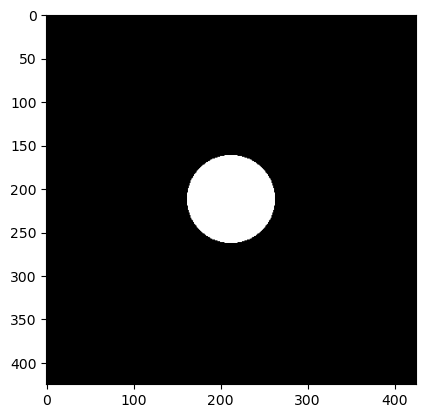

In [177]:
circ, bounds_prc = NSP.utils.boolmask(
    pix_dims=425,
    deg_dims=8.4,
    eccentricity=0,
    angle=0,
    radius=1,
    plot=True,
    return_bounds=True,
    bound_units="prc",
)

print(bounds_prc)


### Select only those gabor filters that fall within the patch region

In [178]:
filts_in_patch, filts_boolvec = location_based_selection(checkpyramid, bounds_prc, verbose=True)

Original number of filters: 86856
Number of filters encapsulated by our patch: 5112


### Project the gaussian checkerboard stimulus to be processed by the selection of filters

In [179]:
# Project the stimulus onto the filters that fall inside the patch region
gauss_output = checkpyramid.project_stimulus(gauss_check_stack, filters=filts_in_patch)

project_stimulus: 100%|██████████| 5112/5112 [01:32<00:00, 55.40it/s]


### Check how many filters each spatial frequency contains

In [180]:
filters_per_freq = filts_per_freq(pyr_pars, filts_in_patch)
print(filters_per_freq)

[54, 294, 1014, 3750]


### Inspect the spatial frequency specific filter outputs for the gaussian checkerboard stimulus

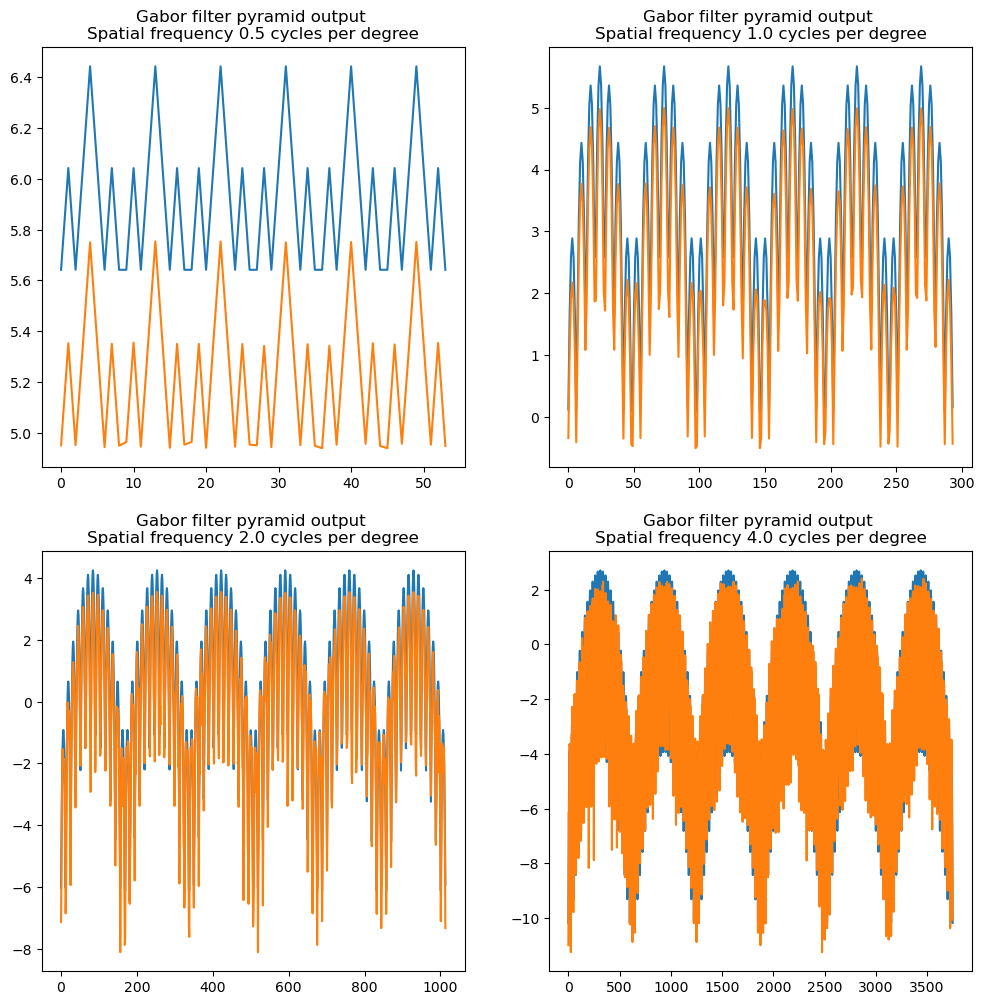

In [181]:
plot_filter_outputs(
    sel_output=gauss_output,
    filters_per_freq_sel=filters_per_freq,
    spat_freqs=pyr_pars["spatial_frequencies"],
    img_indices=[0, 1],
)

### Get a boolean mask for every separate gabor filter orientation

In [182]:
orient_mask = orient_boolmask(filts_in_patch)
orient_mask

array([[ True,  True,  True, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ...,  True,  True,  True]])

In [184]:
output_norm, filters_per_freq_sel, filter_selection, filter_selection_dictlist = (
    select_filters(
        pyramid=checkpyramid,
        filter_list=filts_in_patch,
        output=gauss_output,
        imgs=gauss_check_stack,
        img_no=1,
        spat_freqs=pyr_pars["spatial_frequencies"],
        direction_masks=orient_mask,
        filters_per_freq=filters_per_freq,
        percentile_cutoff=90,  # Het moet maar
        best_n=None,
        verbose=True,
    )
)
# Stack the directions
full_filter = np.sum(np.array(filter_selection), axis=0)

Direction 0, Spatial frequency 0: number of values > percentile = 6
Direction 0, Spatial frequency 1: number of values > percentile = 30
Direction 0, Spatial frequency 2: number of values > percentile = 81
Direction 0, Spatial frequency 3: number of values > percentile = 149
Direction 1, Spatial frequency 0: number of values > percentile = 6
Direction 1, Spatial frequency 1: number of values > percentile = 30
Direction 1, Spatial frequency 2: number of values > percentile = 85
Direction 1, Spatial frequency 3: number of values > percentile = 151
Direction 2, Spatial frequency 0: number of values > percentile = 6
Direction 2, Spatial frequency 1: number of values > percentile = 30
Direction 2, Spatial frequency 2: number of values > percentile = 85
Direction 2, Spatial frequency 3: number of values > percentile = 151
Direction 3, Spatial frequency 0: number of values > percentile = 6
Direction 3, Spatial frequency 1: number of values > percentile = 30
Direction 3, Spatial frequency 2: n

In [185]:
print(f"Total amount of filters: {np.sum(full_filter)}")

Total amount of filters: 1610


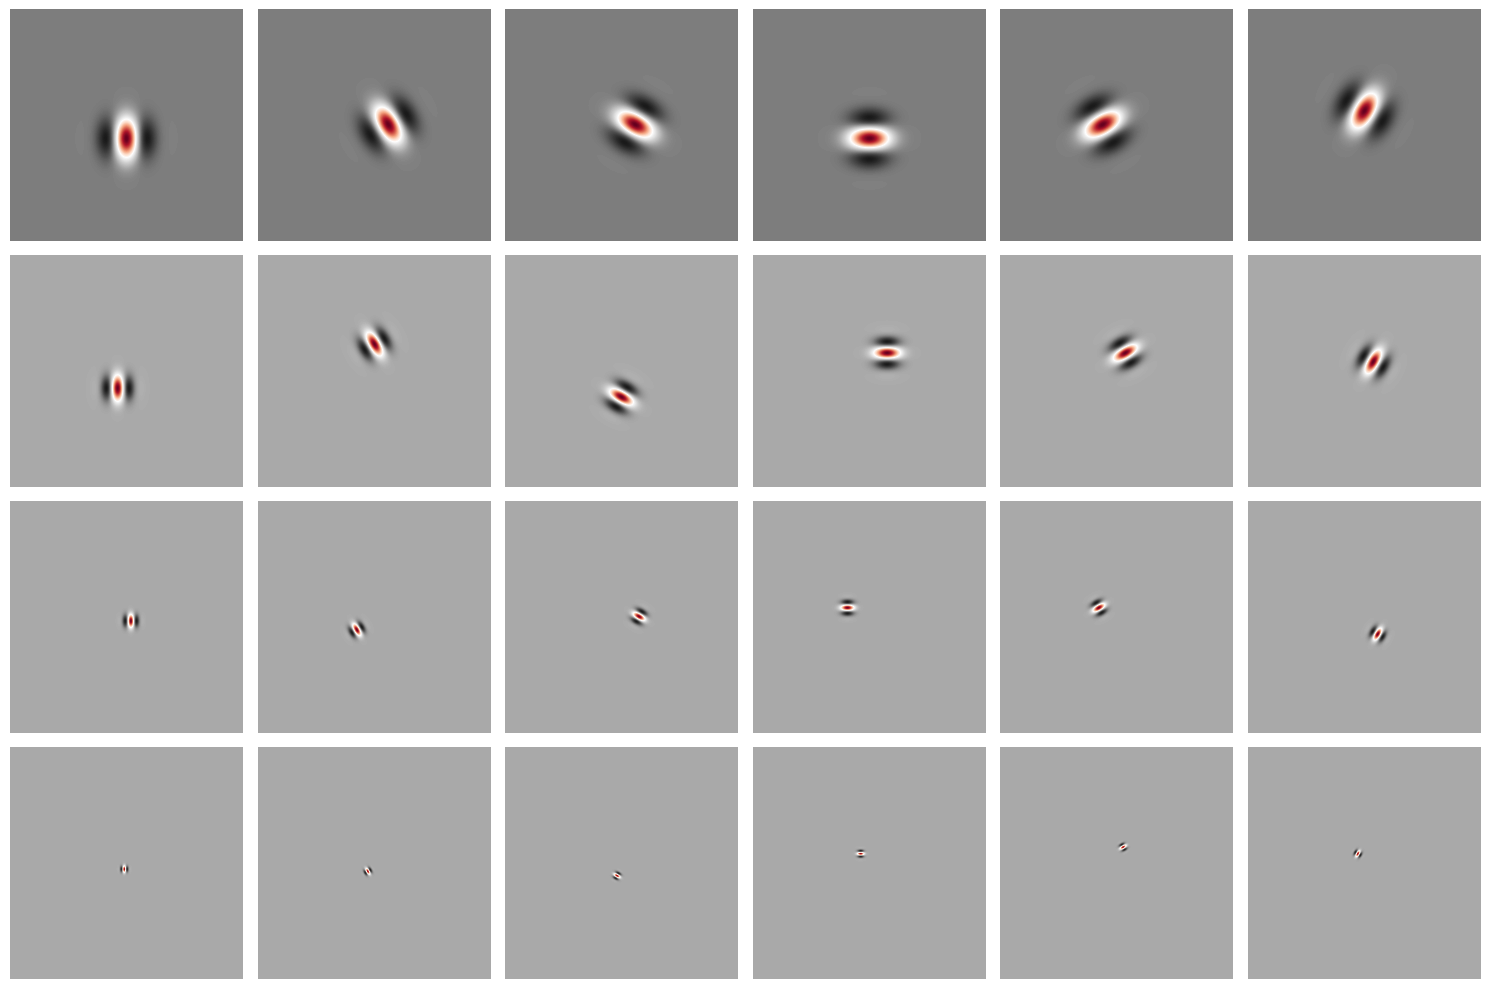

In [186]:
fig, axs = plt.subplots(4, 6, figsize=(15, 10))  # Adjust the figure size as needed

for i in range(6):
    for j in range(4):
        heat_ar = gab_heatmap(
            filter_selection_dictlist,
            filts_per_freq=filters_per_freq_sel,
            dir_idx=i,  # int or "all"
            freq_idx=j,  # int or "all"
            cmap="gray",
            single_filter=True,
            plot=False,
        )

        # Squeeze out the first dimension of heat_ar
        heat_ar = np.squeeze(heat_ar)

        axs[j, i].imshow(heat_ar, cmap='RdGy_r')  # Display the heatmap on the j-th row and i-th column subplot
        axs[j, i].axis("off")

plt.tight_layout()
plt.show()

### Visualise the gabor filters to inspect whether we have made a sensible selection for our current patch

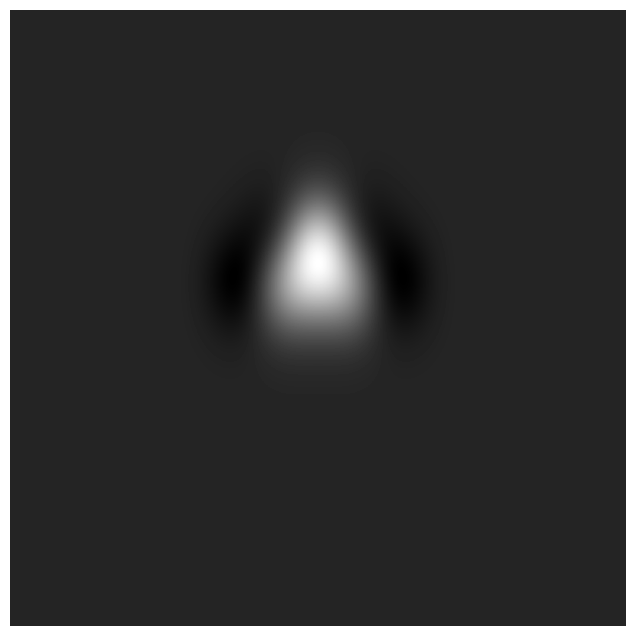

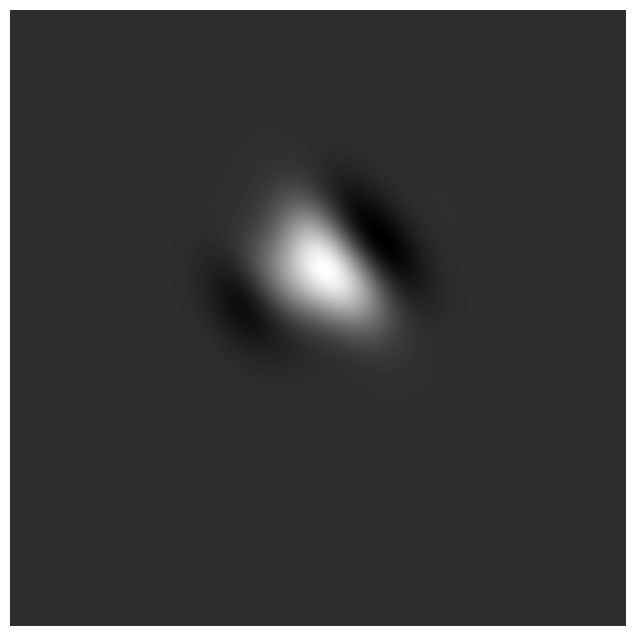

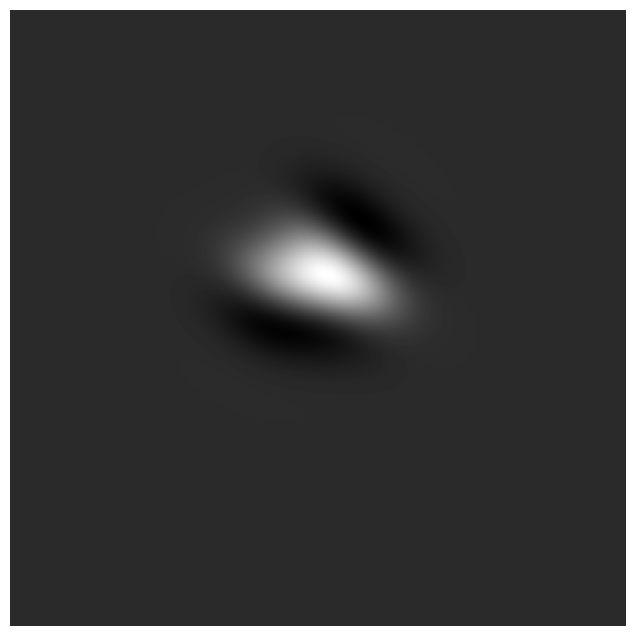

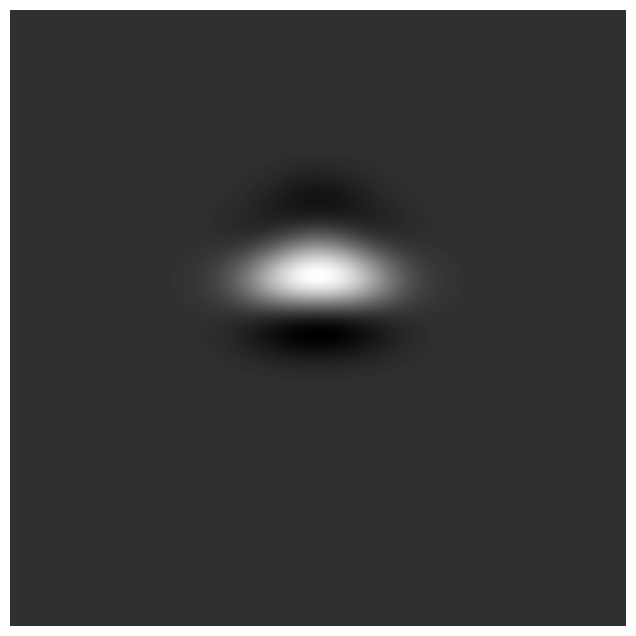

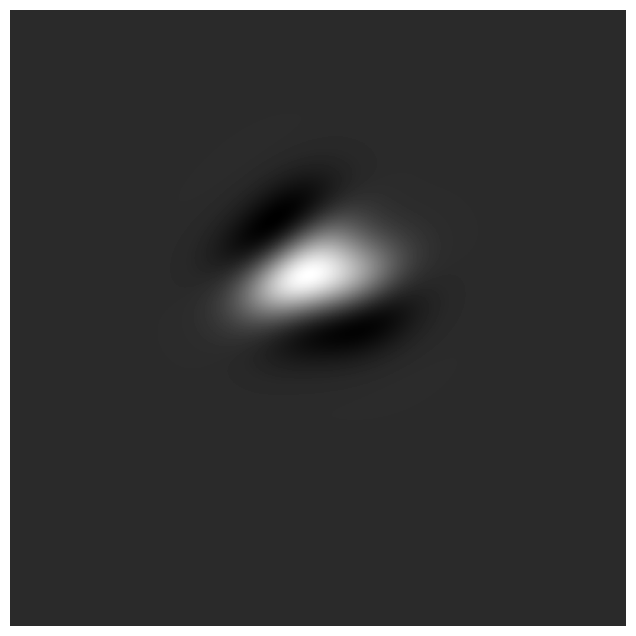

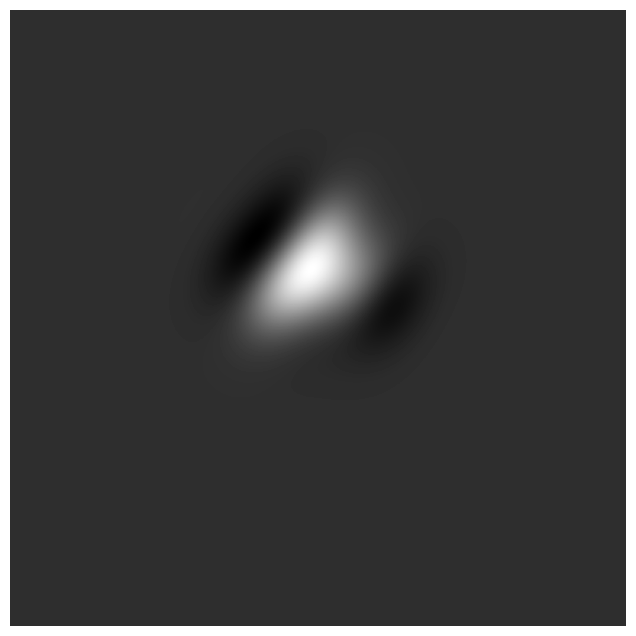

In [140]:
for i in range(6):
    heat_ar = gab_heatmap(
        filter_selection_dictlist,
        filts_per_freq=filters_per_freq_sel,
        dir_idx=i, # int or "all"
        freq_idx=0, # int or "all"
        cmap="gray",
        single_filter=False
    )

    plt.axis("off")

### This function is not super useful anymore as it relies on a boolean vector that is based on the original pyramid filter size, but as we already do a location based preselection, this becomes cumbersome. 

Luckily we can also use the dictionary information as input to view a filter

/home/rfpred/envs/rfenv/lib/python3.11/site-packages/matplotlib/animation.py:892: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


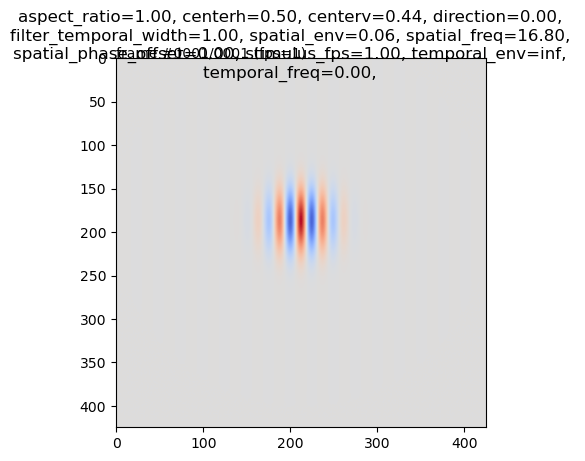

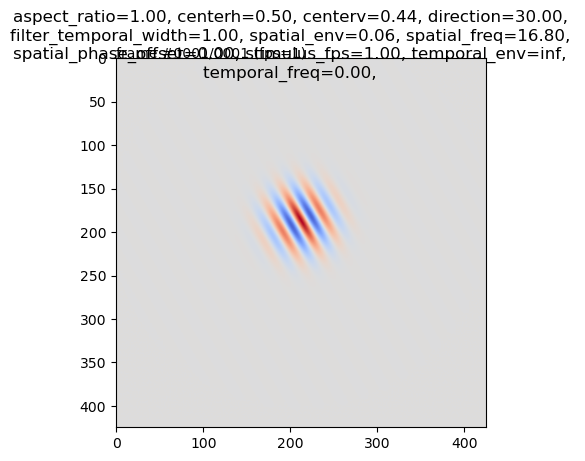

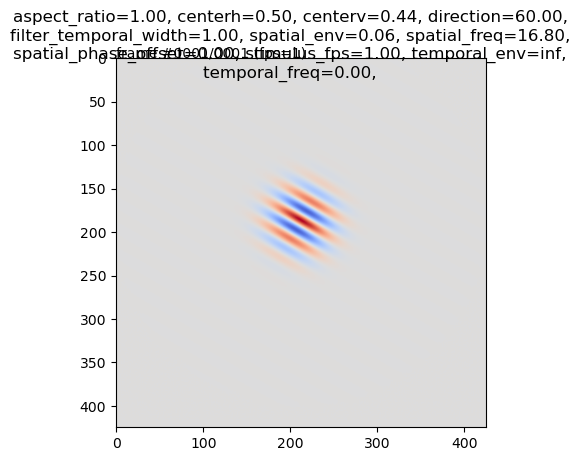

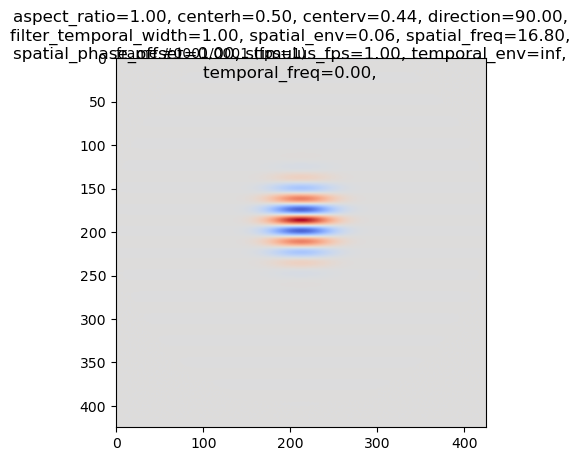

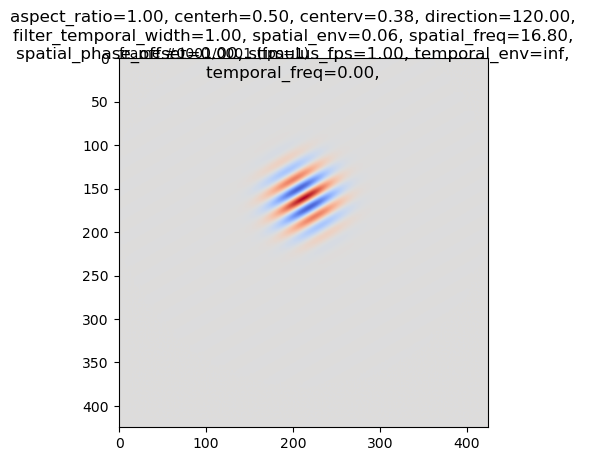

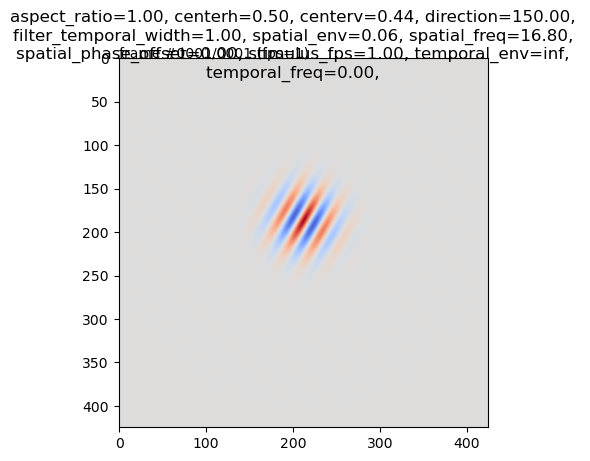

In [141]:
filt_no = 10
for this_orient in range(len(filter_selection)):
    checkpyramid.view.show_filter(filter_selection_dictlist[this_orient][filt_no])
    plt.show()

### Continue with the analyses